### Código en MySQL Forecast con Movimiento Browniano geométrico para precio de acciones

In [1]:
#cargamos librerias
import pandas as pd
from sqlalchemy import create_engine, text
import pymysql as pymysql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tabulate import tabulate
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np

In [2]:
#Creamos la conexion
usuario = "root"
contraseña = ""
host = "localhost"
base_de_datos = "stocks"

# Crear cadena de conexión para MySQL
db = f"mysql+pymysql://{usuario}:{contraseña}@{host}/{base_de_datos}"
db = create_engine(db)


#conexion mysql para no guardar en df
conn = pymysql.connect(
    user = "root",
    password = "",
    host = "localhost",
    db = "stocks"
)

Mostramos la tabla jpm

In [16]:
cursor = conn.cursor()


query = "SELECT * FROM jpm LIMIT 10"
cursor.execute(query)
results = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

print(tabulate(results, headers=column_names, tablefmt="psql"))

cursor.close()


+------------+-------------+
| Date       |   Adj_close |
|------------+-------------|
| 2018-07-13 |     91.4267 |
| 2018-07-16 |     95.0542 |
| 2018-07-17 |     94.9854 |
| 2018-07-18 |     95.8708 |
| 2018-07-19 |     94.461  |
| 2018-07-20 |     95.6559 |
| 2018-07-23 |     97.4353 |
| 2018-07-24 |     98.1229 |
| 2018-07-25 |     99.0083 |
| 2018-07-26 |     98.7246 |
+------------+-------------+


In [5]:
#Calculamos los retornos logaritmicos
#cramos columna vacia
cursor = conn.cursor()
query="ALTER TABLE jpm ADD COLUMN log_return FLOAT;"
cursor.execute(query)
cursor.close() 
conn.commit()#guardamos cambios
cursor.close()

#asignamos los retornos logaritmicos
cursor = conn.cursor()
query="""UPDATE jpm AS main_table
JOIN (
    SELECT Date, 
           Adj_Close AS current_Adj_Close, 
           @prev_value AS previous_Adj_Close, 
           @prev_value := Adj_Close
    FROM jpm
    ORDER BY Date ASC
) AS sub_table
ON main_table.Date = sub_table.Date
SET main_table.log_return = CASE WHEN sub_table.previous_Adj_Close IS NOT NULL THEN LOG(sub_table.current_Adj_Close / sub_table.previous_Adj_Close) END
WHERE sub_table.previous_Adj_Close IS NOT NULL;
""" 
cursor.execute(query)
cursor.close() 
conn.commit()#guardamos cambios
cursor.close()

In [15]:
cursor = conn.cursor()

query = "SELECT * FROM jpm LIMIT 10"
cursor.execute(query)
results = cursor.fetchall()

# Obtener los nombres de las columnas
column_names = [desc[0] for desc in cursor.description]

# Convertimos los resultados a una lista de listas
results = [list(row) for row in results]

# Creamos una tabla con tabulate
table = tabulate(results, headers=column_names, tablefmt='psql')

cursor.close()

# Imprimimos la tabla
print(table)
 

+------------+-------------+--------------+
| Date       |   Adj_close |   log_return |
|------------+-------------+--------------|
| 2018-07-13 |     91.4267 |              |
| 2018-07-16 |     95.0542 |  0.0389095   |
| 2018-07-17 |     94.9854 | -0.000723597 |
| 2018-07-18 |     95.8708 |  0.00927785  |
| 2018-07-19 |     94.461  | -0.0148137   |
| 2018-07-20 |     95.6559 |  0.0125699   |
| 2018-07-23 |     97.4353 |  0.0184308   |
| 2018-07-24 |     98.1229 |  0.00703297  |
| 2018-07-25 |     99.0083 |  0.00898274  |
| 2018-07-26 |     98.7246 | -0.00286929  |
+------------+-------------+--------------+


### Creamos el procediemento de la fucion gbm

La funcion de un GBM es la siguiente:

$$S_{t}=S_{0}e^{(\mu - \frac{\sigma^{2}}{2})t + \sigma W_{t}}$$

o tambien se puede escribir como:

$$ dS_{t}= \mu S_{t}dt + \sigma S_{t}dW_{t}$$

```sql
CREATE PROCEDURE gbm(IN t INT, IN mu FLOAT, IN sigma FLOAT, IN S0 FLOAT, IN n INT, IN sims INT)
BEGIN
  DECLARE sim INT DEFAULT 1;
  DECLARE i INT DEFAULT 0;
  DECLARE u1, u2, randStdNormal, W, deltaT, newS FLOAT;
  
  CREATE TABLE IF NOT EXISTS Simulations (
    Simulation INT,
    Time INT,
    Value FLOAT
  );

  WHILE sim <= sims DO
    SET i = 0;
    WHILE i <= t*n DO
      SET deltaT = i/n;
      
      -- Genera una distribucion normal transformacion Box-Muller
      SET u1 = 1.0 - RAND(); 
      SET u2 = 1.0 - RAND();
      SET randStdNormal = SQRT(-2.0 * LOG(u1)) * SIN(2.0 * PI() * u2);
      
      SET W = SQRT(deltaT) * randStdNormal; -- normal * sqrt(deltaT)
      SET newS = S0 * EXP((mu - 0.5 * POW(sigma, 2)) * deltaT + sigma * W);
      INSERT INTO Simulations (Simulation, Time, Value) VALUES (sim, i, newS);
      
      SET i = i + 1;
    END WHILE;
    SET sim = sim + 1;
  END WHILE;

  SELECT * FROM Simulations;
END //
DELIMITER ;
```

In [28]:
#Calculamos y guardamos los inputs


with db.connect() as connection:
    # Encuentra la fecha más reciente
    most_recent_date_str = connection.execute('SELECT MAX(Date) FROM jpm').scalar()
    # Convierte la fecha a datetime
    most_recent_date = pd.to_datetime(most_recent_date_str)

    # Calcula la fecha que fue hace un año desde la fecha más reciente
    one_year_ago = most_recent_date - pd.DateOffset(years=1)

    # Calcula la media y la varianza de los retornos logarítmicos del último año
    mean, std_dev = connection.execute(text("""
        SELECT AVG(log_return), SQRT(VAR_POP(log_return))
        FROM jpm
        WHERE Date >= :one_year_ago
    """), one_year_ago=one_year_ago.date()).fetchone()

    # Guarda S0, el precio más reciente
    most_recent_close = connection.execute(text("""
        SELECT Adj_Close 
        FROM jpm
        WHERE Date = :most_recent_date
    """), most_recent_date=most_recent_date_str).scalar()

data = [["Mean", mean], ["Standard Deviation", std_dev], ["Most Recent Close", most_recent_close]]
print(tabulate(data, headers=["Variable", "Value"], tablefmt="psql"))



+--------------------+-------------+
| Variable           |       Value |
|--------------------+-------------|
| Mean               |   0.0012024 |
| Standard Deviation |   0.0165328 |
| Most Recent Close  | 148.15      |
+--------------------+-------------+


In [25]:
#Ejecutamos la funcion gbm

# Define los parámetros de entrada para el procedimiento
params = {'t': 63, 'mu': mean, 'sigma': std_dev, 'S0': most_recent_close, 'n': 1, 'sims': 1000}

# Ejecuta el procedimiento almacenado
with db.begin() as connection:
    result = connection.execute(text("CALL gbm(:t, :mu, :sigma, :S0, :n, :sims)"), **params)

# Lee los resultados en un DataFrame de pandas
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Imprime el DataFrame
print("Primeras 5 filas:")
print(tabulate(df.head(5), headers='keys', tablefmt='psql'))

print("Últimas 5 filas:")
print(tabulate(df.tail(5), headers='keys', tablefmt='psql'))

Primeras 5 filas:
+----+--------------+--------+---------+
|    |   Simulation |   Time |   Value |
|----+--------------+--------+---------|
|  0 |            1 |      0 | 148.15  |
|  1 |            1 |      1 | 147.953 |
|  2 |            1 |      2 | 149.767 |
|  3 |            1 |      3 | 142.891 |
|  4 |            1 |      4 | 151.791 |
+----+--------------+--------+---------+
Últimas 5 filas:
+-------+--------------+--------+---------+
|       |   Simulation |   Time |   Value |
|-------+--------------+--------+---------|
| 63995 |         1000 |     59 | 153.41  |
| 63996 |         1000 |     60 | 153.751 |
| 63997 |         1000 |     61 | 135.225 |
| 63998 |         1000 |     62 | 125.554 |
| 63999 |         1000 |     63 | 154.322 |
+-------+--------------+--------+---------+


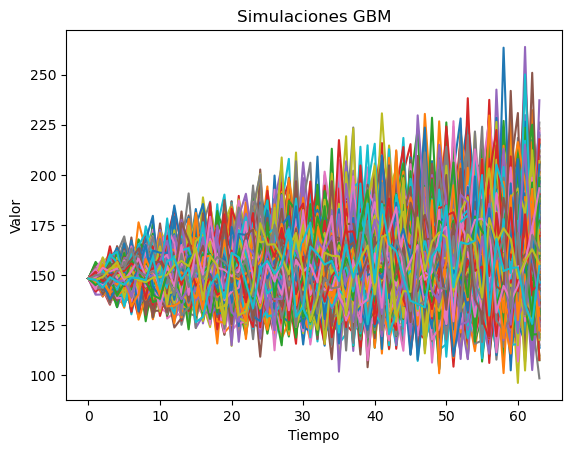

In [26]:
fig, ax = plt.subplots()

# Agrupa el DataFrame por 'Simulation' 
for name, group in df.groupby('Simulation'):
    ax.plot(group['Time'], group['Value'], label=name)

# etiquetas de los ejes
ax.set_title('Simulaciones GBM')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor')



plt.show()


In [29]:
# Inicializa una nueva conexión a la base de datos
with db.begin() as connection:
    # Ejecuta la consulta SQL
    result = connection.execute("""
        SELECT Time, AVG(Value)
        FROM Simulations
        GROUP BY Time
    """)
    

average_simulation = pd.DataFrame(result.fetchall(), columns=['Time', 'AverageValue'])

print(tabulate(average_simulation, headers='keys', tablefmt='psql'))


+----+--------+----------------+
|    |   Time |   AverageValue |
|----+--------+----------------|
|  0 |      0 |        148.15  |
|  1 |      1 |        148.345 |
|  2 |      2 |        148.382 |
|  3 |      3 |        148.701 |
|  4 |      4 |        148.838 |
|  5 |      5 |        149.068 |
|  6 |      6 |        149.165 |
|  7 |      7 |        149.194 |
|  8 |      8 |        150.011 |
|  9 |      9 |        149.332 |
| 10 |     10 |        149.819 |
| 11 |     11 |        149.846 |
| 12 |     12 |        150.34  |
| 13 |     13 |        150.626 |
| 14 |     14 |        150.684 |
| 15 |     15 |        151.202 |
| 16 |     16 |        150.929 |
| 17 |     17 |        151.414 |
| 18 |     18 |        151.361 |
| 19 |     19 |        151.455 |
| 20 |     20 |        151.639 |
| 21 |     21 |        152.629 |
| 22 |     22 |        152.499 |
| 23 |     23 |        152.789 |
| 24 |     24 |        152.336 |
| 25 |     25 |        152.331 |
| 26 |     26 |        152.954 |
| 27 |    

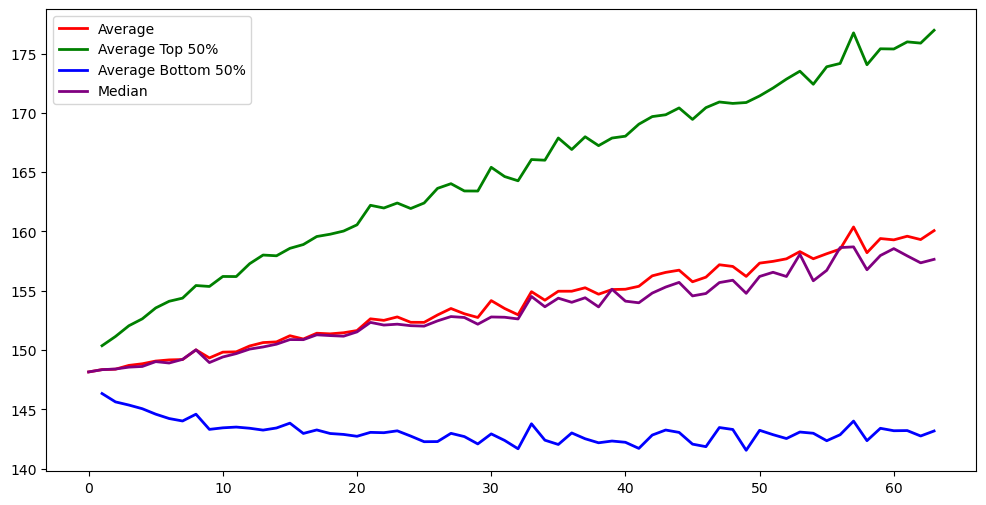

In [48]:
df_pivot = df.pivot(index='Time', columns='Simulation', values='Value')
df_results = pd.DataFrame()

# Calcular y guardar la mediana, el promedio, y los promedios del top 50% y del bottom 50%
df_results['Median'] = df_pivot.median(axis=1)
df_results['Average'] = df_pivot.mean(axis=1)
df_results['Average Top 50%'] = df_pivot.apply(lambda x: x[x > x.median()].mean(), axis=1)
df_results['Average Bottom 50%'] = df_pivot.apply(lambda x: x[x < x.median()].mean(), axis=1)


fig, ax = plt.subplots(figsize=(12,6))


ax.plot(df_results.index, df_results['Average'], label='Average', color='red', linewidth=2)
ax.plot(df_results.index, df_results['Average Top 50%'], label='Average Top 50%', color='green', linewidth=2)
ax.plot(df_results.index, df_results['Average Bottom 50%'], label='Average Bottom 50%', color='blue', linewidth=2)
ax.plot(df_results.index, df_results['Median'], label='Median', color='purple', linewidth=2)


ax.legend()
plt.show()



In [50]:

start_date = most_recent_date
end_date = '2025-12-31'

#días festivos de Estados Unidos
us_holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

# Genera fechas hábiles (excluyendo fines de semana y días festivos de Estados Unidos)
business_days = pd.bdate_range(start=start_date, end=end_date)
business_days = business_days[~business_days.isin(us_holidays)]  # Excluir los días festivos


dates = business_days[:len(df_results)]


df_results['Date'] = dates
df_results['Date'] = df_results['Date'].dt.strftime('%Y%m%d')
print(tabulate(df_results.head(5), headers='keys', tablefmt='psql'))

+--------+----------+-----------+-------------------+----------------------+----------+
|   Time |   Median |   Average |   Average Top 50% |   Average Bottom 50% |     Date |
|--------+----------+-----------+-------------------+----------------------+----------|
|      0 |  148.15  |   148.15  |           nan     |              nan     | 20230712 |
|      1 |  148.341 |   148.345 |           150.362 |              146.329 | 20230713 |
|      2 |  148.397 |   148.382 |           151.139 |              145.624 | 20230714 |
|      3 |  148.554 |   148.701 |           152.045 |              145.357 | 20230717 |
|      4 |  148.612 |   148.838 |           152.629 |              145.048 | 20230718 |
+--------+----------+-----------+-------------------+----------------------+----------+


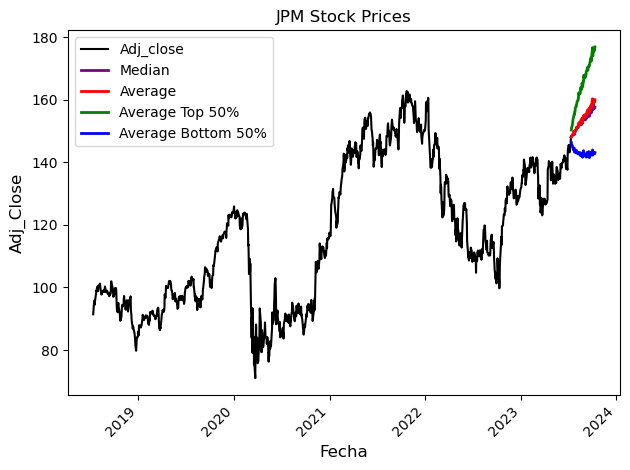

In [138]:
# Leer la tabla "jpm" en un DataFrame
df_jpm = pd.read_sql_table('jpm', db)



# Convertir la columna 'Date' en formato datetime64
df_jpm['Date'] = pd.to_datetime(df_jpm['Date'])
df_results['Date'] = pd.to_datetime(df_results['Date'])

# Graficar la columna 'Adj_Close'
plt.plot(df_jpm['Date'], df_jpm['Adj_close'], label='Adj_close', color='black')

# Agregar el gráfico anterior con la mediana, media y valores superiores e inferiores
plt.plot(df_results['Date'], df_results['Median'], label='Median', color='purple', linewidth=2)
plt.plot(df_results['Date'], df_results['Average'], label='Average', color='red', linewidth=2)
plt.plot(df_results['Date'], df_results['Average Top 50%'], label='Average Top 50%', color='green', linewidth=2)
plt.plot(df_results['Date'], df_results['Average Bottom 50%'], label='Average Bottom 50%', color='blue', linewidth=2)

# Configurar el título y las etiquetas de los ejes
plt.title('JPM Stock Prices', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Adj_Close', fontsize=12)

# Ajustar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45, ha='right')

# Ajustar el intervalo de visualización de las etiquetas del eje x
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)


plt.tight_layout()


plt.legend()
plt.show()

